In [73]:
# Organize imports
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.special import gammaincinv
from scipy.stats import norm

from spl_examples import (
    use_audio_samples_to_compute_SL_and_PSD,
    plot_PSDs,
)

In [74]:
# Assign speed of sound
# See: https://en.wikipedia.org/wiki/Speed_of_sound
SPEED_OF_SOUND = 343  # [m/s]

In [75]:
# Assign microphone specifications
# See: https://github.com/OpenAcousticDevices/Datasheets/blob/main/AudioMoth_Dev_1_0_1_Datasheet/AudioMoth_Dev_1_0_1_Datasheet.pdf
AUDIOMOTH_SENSITIVITY = -38.0  # [dB re V/Pa]
AUDIOMOTH_GAIN = 15.0  # [dB]

In [76]:
# Assign the archive of interest
ARCHIVE_DIR = Path("2025-01-6-dataset-archive")
DATASET_DIR = "dataset"
DATASET_CSV = "dataset.csv"

In [77]:
# Assign engine types to consider
ENGINE_TYPES = [
    "4-Cycle",
    "Reciprocating",
    "Turbo-fan",
    "Turbo-prop",
    "Turbo-shaft",
    "Ambient",
]

In [78]:
# Read the dataset, append the engine type, and rename "Unknown" engine type to "Ambient"
csv_path = ARCHIVE_DIR / DATASET_CSV
dataset = pd.read_csv(csv_path)
dataset["engine_type"] = dataset["filename"].apply(lambda fn: fn.split("_")[2])
dataset.loc[dataset["engine_type"] == "Unknown", "engine_type"] = "Ambient"

In [79]:
# Use audio samples to compute source level and power spectral density for each recording in the dataset
audio_dir = ARCHIVE_DIR / DATASET_DIR
S_dB_re_V_per_Pa = AUDIOMOTH_SENSITIVITY
gain_dB = AUDIOMOTH_GAIN
c = SPEED_OF_SOUND
results = use_audio_samples_to_compute_SL_and_PSD(
    audio_dir,
    dataset,
    S_dB_re_V_per_Pa,
    gain_dB,
    c,
)

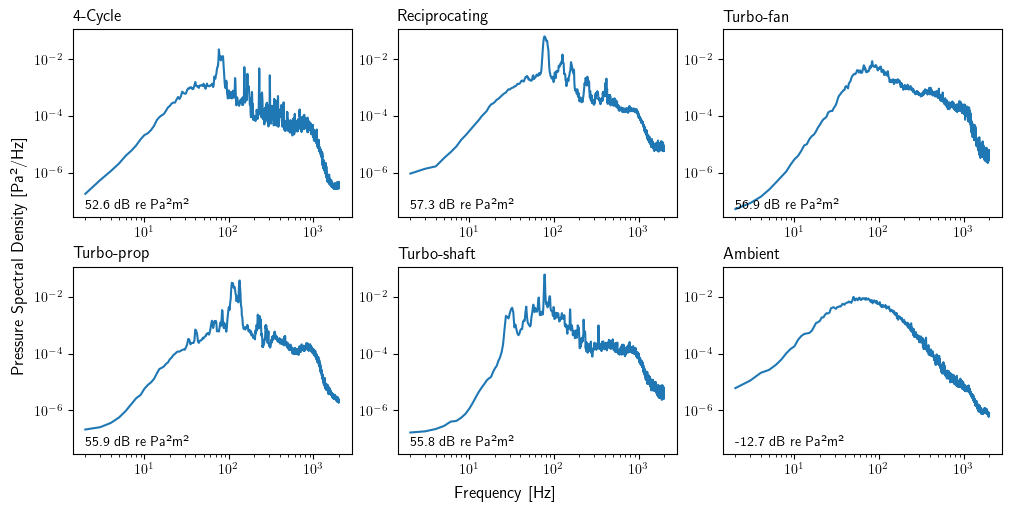

In [80]:
# Plot average pressure spectral densities for all engine types
# Note that source level is shown in the lower left, but that source level makes little sense for ambient noise
plot_type = "average_psd"
plot_file = DATASET_CSV.replace(".csv", f"_{plot_type}.pdf")
engine_types = ENGINE_TYPES
archive_dir = ARCHIVE_DIR
plot_PSDs(results, plot_type, engine_types, archive_dir, plot_file)

In [81]:
# Select the "4-Cycle" source level, and specify the corresponding bandwidth
SL = 52.6  # dB re Pa^2m^2
W = 200  # Hz

# Compute the propagation loss assuming spherical spreading at 3 km
distance = 3000 # m
PL = 20 * math.log10(distance)  # dB re m^2

# Estimate the noise density, and level
noise_density = 1e-3  # Pa^2/Hz
NL = 10 * math.log10(noise_density * W)  # dB re Pa^2

# Since only a single hydrophone is used, note the array gain
AG = 0

# Use the passive sonar equation to obtain the SNR at the microphone
SNR_m = SL - PL - NL + AG

print(f"SNR at the microphone for a '4-Cycle' source at 1000 m: {SNR_m:.1f} dB")

SNR at the microphone for a '4-Cycle' source at 1000 m: -10.0 dB


In [82]:
# Specify the processing time and compute the time bandwidth product
T_p = 1
M = T_p * W
W

200

In [83]:
# Specify the probabilities of false alarm and detection (the operating point), and,
# since M >> 1, use (2.76) to compute the corresponding detection threshold
P_f = 0.05
P_d = 0.95
phi_f = norm.ppf(1 - P_f)
phi_d = norm.ppf(1 - P_d)
SNR_bar_d = -5 * math.log10(M) + 10 * math.log10(phi_f - phi_d) - 10 * math.log10(1 + phi_d / math.sqrt(M))
SNR_bar_d

-5.796583171785711

In [84]:
# Use the exact solution relating the operating point to the detection threshold (2.81)
def snr_bar_d(M, P_f, P_d):
    return 10 * math.log10((gammaincinv(int(M), 1 - P_f) / gammaincinv(int(M), 1 - P_d)) - 1)

# Use bisection to find the root of the exact solution, the probability of detection component
# of the operating point, interpreting the SNR at the microphone as the detection threshold
def bisect(M, P_f, SNR_m):
    def f(P_d, M, P_f, SNR_m):
        return snr_bar_d(M, P_f, P_d) - SNR_m
    epsilon = 1e-6
    f_a = f(P_f + epsilon, M, P_f, SNR_m)
    f_b = f(1 - epsilon, M, P_f, SNR_m)
    if np.sign(f_a) == np.sign(f_b):
        P_d = np.nan
    else:
        P_d = optimize.bisect(f, P_f + epsilon, 1 - epsilon, args=(M, P_f, SNR_m))
    return P_d
P_d = bisect(M, P_f, SNR_m)
P_d

0.4000140541940183

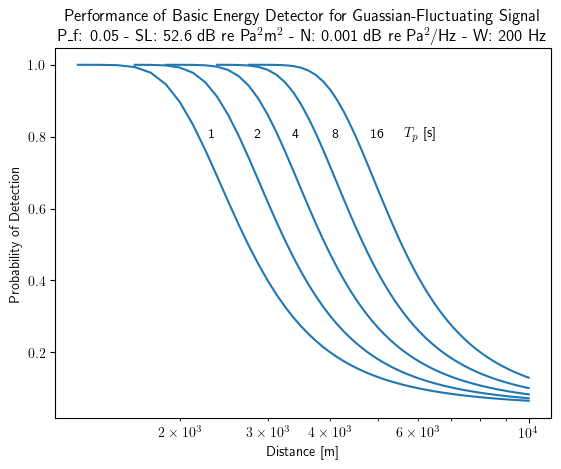

In [85]:
plt.rcParams['text.usetex'] = True
clr = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
fig, axs = plt.subplots()
distance = np.array(range(10000, 250, -125))
for T_p in [1, 2, 4, 8, 16]:

    # Estimate the time bandwidth product
    M = T_p * W

    P_d = np.array([])
    for d in distance:
        
        # Compute the propagation loss assuming spherical spreading
        PL = 20 * math.log10(d)  # dB re m^2

        # Use the passive sonar equation to obtain the SNR at the microphone
        SNR_m = SL - PL - NL + AG

        # Use bisection to find the root of the exact solution, the probability of detection component
        # of the operating point, interpreting the SNR at the microphone as the detection threshold
        P_d = np.append(P_d, bisect(M, P_f, SNR_m))

    axs.semilogx(distance, P_d, clr)
    axs.text(max(distance[P_d > 0.8]) * 1.075, 0.8, T_p)

axs.text(max(distance[P_d > 0.8]) * 1.25, 0.8, "$T_p$ [s]")
axs.set_xlabel("Distance [m]", fontweight="semibold")
axs.set_ylabel("Probability of Detection", fontweight="semibold")
title = "Performance of Basic Energy Detector for Guassian-Fluctuating Signal\n"
title += f"P_f: {P_f} - SL: {SL} dB re Pa$^2$m$^2$ - N: {noise_density} dB re Pa$^2$/Hz - W: {W} Hz"
axs.set_title(title)
plt.savefig("Detector-Performance.pdf")    